In [14]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import math
from jp_doodle import dual_canvas
from IPython.display import display
import pandas as pd

In [38]:
df = pd.read_hdf("/data_share/Girlsday/total_test.h5")
df

,index,1153,1154,1155,1156,1157,1158,1159,1160,1161,...,event,pdg,mass,energy,px,py,pz,theta,phi,p
0,0,0,0,0,0,0,0,0,0,0,...,12,13,0.105658,3.331050,-1.210217,2.273346,2.109977,0.884136,2.059959,3.329374
1,0,0,0,0,0,0,0,0,0,0,...,15,13,0.105658,3.331050,-1.210217,2.273346,2.109977,0.884136,2.059959,3.329374
2,0,0,0,0,0,0,0,0,0,0,...,20,13,0.105658,3.331050,-1.210217,2.273346,2.109977,0.884136,2.059959,3.329374
3,0,0,0,0,0,0,0,0,0,0,...,28,13,0.105658,3.331050,-1.210217,2.273346,2.109977,0.884136,2.059959,3.329374
4,0,0,0,0,0,0,0,0,0,0,...,47,13,0.105658,3.331050,-1.210217,2.273346,2.109977,0.884136,2.059959,3.329374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,0,0,0,0,0,0,0,0,0,0,...,69,-11,0.000511,1.855958,0.080946,-1.820123,0.353808,1.380147,-1.526136,1.855958
11,0,0,0,0,0,0,0,0,0,0,...,72,22,0.000000,0.000511,0.080946,-1.820123,0.353808,1.380147,-1.526136,1.855958
12,0,0,0,0,0,0,0,0,0,0,...,76,-11,0.000511,1.855958,0.080946,-1.820123,0.353808,1.380147,-1.526136,1.855958
13,0,0,0,0,0,0,0,0,0,0,...,77,-11,0.000511,0.027411,0.080946,-1.820123,0.353808,1.380147,-1.526136,1.855958


In [41]:
class TrackingSegment:
    
    def __init__(self, radius, begin, end):
        self.radius = radius
        self.begin = begin
        self.end = end
        self.hit = False
        t = np.linspace(self.begin, self.end, 100)
        self.x = self.radius*np.cos(t)
        self.y = self.radius*np.sin(t)
        
        
    def check_hit(self, particle):
        d=math.sqrt(particle.x**2 + particle.y**2)
        a=(self.radius**2-particle.radius**2+d**2)/(2*d)
        h=math.sqrt(abs(self.radius**2-a**2))
        x2=a*(particle.x)/d   
        y2=a*(particle.y)/d   
        x3=x2+h*(particle.y)/d     
        y3=y2-h*(particle.x)/d 

        x4=x2-h*(particle.y)/d
        y4=y2+h*(particle.x)/d
        
        
        rho = math.sqrt(x4**2 + y4**2)
        theta = np.arctan2(y4,x4)
        
        if theta < 0:
            theta += 2*np.pi
        
        #print(theta, self.begin, self.end)
        #print(self. radius, self.begin/2/np.pi, theta/2/np.pi, self.end/2/np.pi, self.hit)
        if theta > self.begin and theta < self.end:
            self.hit = True
        else:
            self.hit = False
        #print(self.hit)
        return x4, y4
    
    def draw(self, ax):
        ax.plot(self.x,self.y, color = self.check_color(), linewidth = 4)
        return 
        
    def check_color(self):
        if self.hit:
            return "green"
        else:
            return "black"

In [42]:
class ECLSegment:
    def __init__(self, radius, begin, end, width):
        self.radius = radius
        self.begin = begin
        self.end = end
        self.width = width
        self.hit = False
        
    def check_hit(self, particle):
        pass
    
    def draw(self, ax):
        t = np.linspace(self.begin, self.end, 100)
        x = self.radius*np.cos(t)
        y = self.radius*np.sin(t)
        ax.plot(x,y, color = self.check_color())
        x_ = (self.radius+self.width)*np.cos(t)
        y_ = (self.radius+self.width)*np.sin(t)
        ax.plot(x_,y_, color = self.check_color())
        ax.plot([x[0], x_[0]], [y[0], y_[0]], color = self.check_color())
        ax.plot([x[-1], x_[-1]], [y[-1], y_[-1]], color = self.check_color())
        return 
        
    def check_color(self):
        if self.hit:
            return "green"
        else:
            return "black"

In [43]:
class Tracking:
    def __init__(self, layers, n_segments):
        self.n_segments = n_segments
        self.layers = []
        for l in range(layers):
            self.layers.append([])
            len_segment = 2*np.pi/(n_segments+2*l)
            for i in range(n_segments+2*l):
                print(l, i, round(len_segment*i+(0.2/(l+1)), 3), round(len_segment*(i+1)-(0.2)/(l+1), 3))
                self.layers[l].append(TrackingSegment((l+1)/2, len_segment*i+(0.2/(l+1)), len_segment*(i+1)-(0.2)/(l+1)))
        self.ecl = []
        l = len(self.layers)
        len_segment = 2*np.pi/(n_segments+2*l)
        for i in range(n_segments+2*l):
            self.ecl.append(ECLSegment((l+1)/2, len_segment*i+(0.2/(l+1)), len_segment*(i+1)-(0.2)/(l+1), width = 1))

    def draw(self, ax, particle):
        for l in self.layers:
            for s in l:
                s.check_hit(particle)
                s.draw(ax)
        for e in self.ecl:
            e.draw(ax)

In [44]:
class Particle:
    def __init__(self,r, phi):
        self.x = r*np.cos(phi)
        self.y = r*np.sin(phi)
        self.radius = r
        self.phi = phi
    
    def draw(self, ax):
        self.x = self.radius*np.cos(self.phi)
        self.y = self.radius*np.sin(self.phi)
        theta = np.linspace(0,np.pi,100)
        x = self.radius*np.cos(theta+self.phi)+self.x
        y = self.radius*np.sin(theta+self.phi)+self.y
        c = "blue" if self.radius<0 else "red"
        self.lines = ax.plot(x,y,color = c)

0 0 0.2 1.371
0 1 1.771 2.942
0 2 3.342 4.512
0 3 4.912 6.083
1 0 0.1 0.947
1 1 1.147 1.994
1 2 2.194 3.042
1 3 3.242 4.089
1 4 4.289 5.136
1 5 5.336 6.183


interactive(children=(FloatSlider(value=5.0, description='r', max=5.0, min=-5.0), FloatSlider(value=0.0, descr…

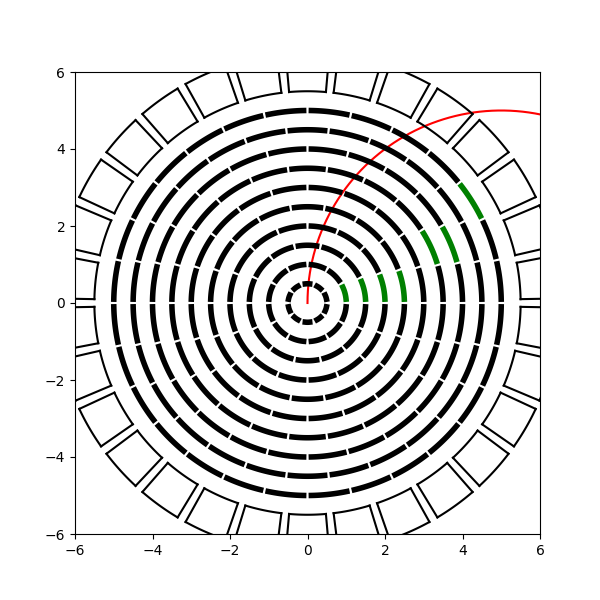

In [45]:
# set up plot
fig, ax = plt.subplots(figsize=(6,6))
ax.set_ylim([-6,6])
ax.set_xlim([-6,6])

# generate x values
x = np.linspace(0, 2 * np.pi, 100)
 
tracking = Tracking(10,10)
particle = Particle(10,0)
 
@widgets.interact(phi = (-np.pi,np.pi, 0.1), r = (-5,5,0.1))

def update(r=10, phi = 0):
    """Remove old lines from plot and plot new one"""
    if r != 0 :
        [l.remove() for l in ax.lines]
        particle.radius = r
        particle.phi = phi
        particle.draw(ax)
        tracking.draw(ax, particle)

In [7]:
class ECLCrystal:
    def __init__(self, x, y, edge):
        self.x = x
        self.y = y
        self.edge = edge
        self.hit = False
        self.chosen = False
        
    def draw(self,ax):
        ax.rect(name=f"crystal{self.x}{self.y}", x=self.x, y=self.y, w = self.edge, h = self.edge, color="green", fill = False)
        #ax.add_patch(Rectangle((self.x, self.y), self.edge, self.edge, edgecolor = "black", picker = True, pickradius = self.edge, facecolor = self.check_color(), linewidth = 1))
    
    def check_color(self):
        if self.chosen:
            return "red"
        elif self.hit:
            return "green"
        else:
            return "grey"

In [8]:
class ECal:
    def __init__(self, nrows, ncols, crystal_edge = 10):
        self.crystals = []
        for r in range(nrows):
            self.crystals.append([])
            for c in range(ncols):
                self.crystals[r].append(ECLCrystal(r*crystal_edge, c*crystal_edge, crystal_edge))
    
    def draw(self, ax):
        for r in self.crystals:
            for c in r:
                c.draw(ax)
    def get_crystal(self, rectangle):
        x,y = rectangle.get_xy()
        for i,r in enumerate(self.crytals):
            for j,c in enumerate(r):
                if x == c.x and y==c.y:
                    return i,j

In [34]:
class SelectorLasso:
    def __init__(self, name, ax, ecal):
        self.selected_crystalls = []
        self.name = name
        self.ax = ax
        self.ax.do_lasso(self.callback, delete_after = False, name = self.name)
        self.ecal = ecal
        
    def callback(names_mapping):
        self.m = names_mapping
        self.selected_crystalls[:] = []
        for name in names_mapping:
            print(name)
            self.selected_crystalls.append(name)
            self.ax.change(name, color = "red")
            
    def reset(self,a):
        with self.ax.delay_redraw():
            self.ax.forget_objects([self.name])
            self.ecal.draw(self.ax)
            self.ax.do_lasso(self.callback, delete_after = False, name = self.name)
            self.selected_crystalls = []
            
    def connect_buttons(self, button):
        button.on_click(self.reset)

In [ ]:
def callback(names_mapping):
    selected[:] = []
    for name in names_mapping:
        selected.append(name)
        demo2.change(name, color = "red")

        
def reset(self,a):
    with self.ax.delay_redraw():
        demo2.forget_objects([self.name])
        ecal.draw(self.ax)
        demo2.do_lasso(callback, delete_after = False, name = "lasso")
        seleced = []

button = widgets.Button(
    description='Reset',
    disabled=False,
    button_style='',
    tooltip='Reset',
)

In [35]:
demo2 = dual_canvas.DualCanvasWidget(width=1600, height=500)
ecal = ECal(10,10)#ECal(144,46)
#ecal.draw(demo2)
lasso = SelectorLasso("lasso", demo2, ecal)
lasso.reset(0)
button = widgets.Button(
    description='Reset',
    disabled=False,
    button_style='',
    tooltip='Reset',
)
lasso.connect_buttons(button)
demo2.do_lasso(lasso.callback, delete_after = False, name = "lasso")
display(demo2)
button

DualCanvasWidget(status='deferring flush until render')

Button(description='Reset', style=ButtonStyle(), tooltip='Reset')

In [50]:
lasso.m

AttributeError: 'SelectorLasso' object has no attribute 'm'

In [46]:
demo2 = dual_canvas.DualCanvasWidget(width=320, height=220)

def make_circles():
    for i in range(20, 400, 20):
        for j in range(20, 400, 20):
            name = "circle" + repr((i,j))
            demo2.rect(name=name, x=i, y=j, w=4, h=4, color="green")
            
selected = []
def lasso_callback(names_mapping):
    selected[:] = []
    for name in names_mapping:
        selected.append(name)
        demo2.change(name, color="pink")

lasso_name = "my_lasso_polygon"

def reset_lasso():
    
    with demo2.delay_redraw():
        demo2.forget_objects([lasso_name])
        make_circles()
        demo2.do_lasso(c.lasso_callback, delete_after=False, name=lasso_name)

reset_lasso()
demo2.fit()
demo2.debugging_display()
display(demo2)

DualCanvasWidget(status='deferring flush until render')

In [47]:
selected

['circle(80, 300)',
 'circle(100, 300)',
 'circle(120, 300)',
 'circle(140, 300)',
 'circle(80, 280)',
 'circle(100, 280)',
 'circle(120, 280)',
 'circle(140, 280)',
 'circle(160, 280)',
 'circle(180, 280)',
 'circle(200, 280)',
 'circle(220, 280)',
 'circle(60, 260)',
 'circle(80, 260)',
 'circle(100, 260)',
 'circle(120, 260)',
 'circle(140, 260)',
 'circle(160, 260)',
 'circle(180, 260)',
 'circle(200, 260)',
 'circle(220, 260)',
 'circle(240, 260)',
 'circle(260, 260)',
 'circle(60, 240)',
 'circle(80, 240)',
 'circle(100, 240)',
 'circle(120, 240)',
 'circle(140, 240)',
 'circle(160, 240)',
 'circle(180, 240)',
 'circle(200, 240)',
 'circle(220, 240)',
 'circle(240, 240)',
 'circle(260, 240)',
 'circle(280, 240)',
 'circle(60, 220)',
 'circle(80, 220)',
 'circle(120, 220)',
 'circle(140, 220)',
 'circle(160, 220)',
 'circle(180, 220)',
 'circle(200, 220)',
 'circle(220, 220)',
 'circle(240, 220)',
 'circle(260, 220)',
 'circle(280, 220)',
 'circle(300, 220)',
 'circle(40, 200)',
 